In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/privacy_permutation/')

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

#from torchsummary import summary
#from torchinfo import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import scipy.signal as signal

import utils

# %matplotlib widget
%matplotlib notebook
%matplotlib inline

C:\Users\nelso\AppData\Local\Temp\ipykernel_3756\1921449817.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [45]:
m = np.array([[1,2],[3,4]])
P = np.array([[0,1],[1,0]])      


P @ m @ P.T

array([[4, 3],
       [2, 1]])

In [64]:
# apply softmax to a random tensor

x = torch.randn(4,4)

soft_x = F.gumbel_softmax(x, hard=True)

print(soft_x), print(x)

tensor([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])
tensor([[-0.6276, -1.5625,  0.2723,  0.3682],
        [-0.5819,  0.8675, -1.5186, -0.2561],
        [ 0.4456, -1.5515, -1.5397,  0.8504],
        [-1.2520,  1.1802, -0.0750, -0.1462]])


(None, None)

Text(0.5, 1.0, 'Arnold Transform')

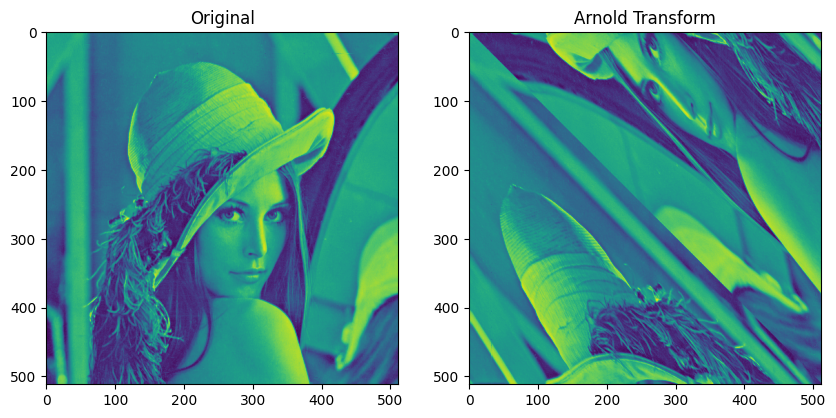

In [37]:
# arnold transform

def arnold_transform(img, N):
    """
    Apply Arnold Transform to an image
    :param img: original image
    :param N: number of iterations
    :return: transformed image
    """
    img = np.array(img)
    img_ = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            I,J = (np.array([[1,1],[1,0]]) @ np.array([i,j]) ) % N
            img_[I,J] = img[i,j]
        

    return img_

#load lenna
lenna = plt.imread('lenna.png')
lenna = np.mean(lenna, axis=2)

#apply arnold transform

lenna_arnold = arnold_transform(lenna, 512)

#plot lenna and lenna_arnold

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(lenna)
ax[0].set_title('Original')
ax[1].imshow(lenna_arnold)
ax[1].set_title('Arnold Transform')



In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
utils.setup_seed(1312)

In [ ]:
img_size = 33

test = utils.Permutar(img_size, 1)
test.key.reshape(33,33)

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform=transforms.Compose([
    T.Resize((33,33)),
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
    ])

trainset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform,)
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

fake_loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False,drop_last=True)
a = list(fake_loader)
b = test.desordenar(a[0][0])

trainset_disorderly = torch.utils.data.TensorDataset(b,a[0][1])

train_loader = torch.utils.data.DataLoader(trainset_disorderly, batch_size=64, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True)

In [ ]:
a = next(iter(train_loader))
X,y = [a[0][0], a[1][0]]
fig,axs = plt.subplots(1,2,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):
  print(X.data.shape)
  pic = X.data.cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  print(y)
  label = testset.classes[y]

  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from permuted_newtork import PermutedNetwork_2, PermutedNetwork, NormalNetwork

model = NormalNetwork().to(device)

In [ ]:
summary(model, (1, 1, 33, 33))

In [ ]:
class PermutationModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.perm_1, self.perm_2 = self.matrix_perm()
        self.perm_1 = nn.Parameter(self.perm_1, requires_grad=True)
        self.perm_2 = nn.Parameter(self.perm_2, requires_grad=True)

    def matrix_perm(self):
        p_1 = np.random.permutation(33)
        p_1 = F.gumbel_softmax(torch.tensor(p_1, dtype=torch.float32, device=self.device), hard=True)
        p_2 = np.random.permutation(33)
        p_2 = F.gumbel_softmax(torch.tensor(p_2, dtype=torch.float32, device=self.device), hard=True)

        return p_1, p_2
    
    def forward(self, x):
        x = self.perm_1 @ x @ self.perm_2
        x = self.model(x)
        return x


    def forward(self, x):
        x = self.permutation(x)
        x = self.model(x)
        return x

In [ ]:
# Define the loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the network
epochs = 5

trainLoss = torch.zeros(epochs)
testLoss  = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
testAcc   = torch.zeros(epochs)

for e in range(epochs):
    model.train()

    batchLoss = []
    batchAcc  = []

    for images, labels in train_loader:
        
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append( (output.argmax(dim=1) == labels).type(torch.float).mean() )

    trainLoss[e] = torch.tensor(batchLoss).mean()
    trainAcc[e]  = torch.tensor(batchAcc).mean()

    model.eval()
    batchLoss = []
    batchAcc  = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) #test.desordenar(images).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            batchLoss.append(loss.item())
            batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

    testLoss[e] = torch.tensor(batchLoss).mean()
    testAcc[e]  = torch.tensor(batchAcc).mean()

    print(f"Epoch {e+1}/{epochs} Test Loss: {testLoss[e]:.3f} Test Acc: {testAcc[e]:.3f}, Train Loss: {trainLoss[e]:.3f} Train Acc: {trainAcc[e]:.3f}")

